In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.1 MB/s eta 0:00:00


In [9]:
import pandas as pd
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.stats import shapiro

In [3]:
# Монтируем Google Диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/trial/pivot_df.csv', sep = ';', encoding='Windows-1251', parse_dates = [0], index_col = [0]) #Загружаем спарсенные данные Росстата по РФ

In [6]:
df = df[['1']] #работаем только с инфляцией

In [10]:
# Преобразуем временной ряд в одномерный массив значений
time_series = df.values.flatten()

# Применяем тест Шапиро-Уилка
statistic, p_value = shapiro(time_series)

# Выводим результаты теста
print("Статистика теста:", statistic)
print("p-значение:", p_value)

# Оцениваем результаты теста
alpha = 0.05
if p_value > alpha:
    print("Принимаем нулевую гипотезу - данные имеют нормальное распределение")
else:
    print("Отвергаем нулевую гипотезу - данные не имеют нормального распределения")

Статистика теста: 0.7184164524078369
p-значение: 6.0516994056712664e-21
Отвергаем нулевую гипотезу - данные не имеют нормального распределения


In [11]:
df.index = pd.to_datetime(df.index)

In [12]:
monthly_median = df.groupby(df.index.month).median()

# Выводим результат
monthly_median

,1
1,101.010
2,100.780
3,100.630
4,100.540
5,100.510
6,100.510
7,100.525
8,100.090
9,100.295
10,100.525


In [13]:
df.index = pd.to_datetime(df.index)

array([[<Axes: title={'center': '1'}>]], dtype=object)

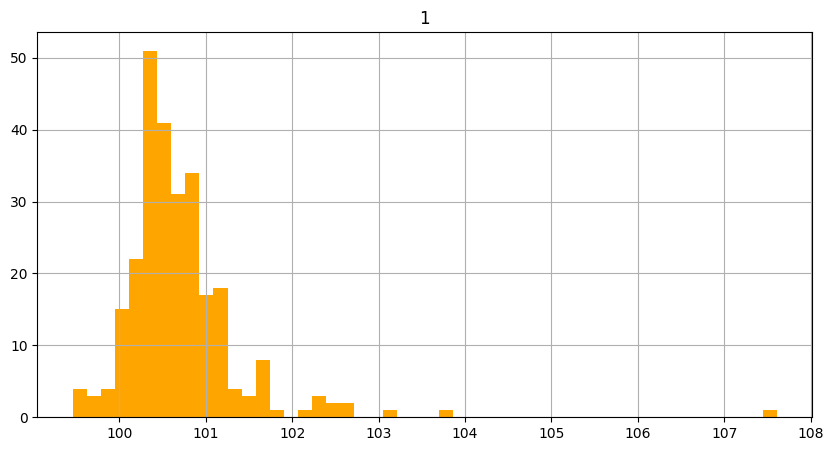

In [14]:
df.hist(bins = 'fd', figsize=(10, 5), color='orange')

In [16]:
def remove_outliers_iqr(df, column):
    # Вычисление первого и третьего квартилей
    Q1 = df[column].quantile(0.25)  # Первый квартиль (25-й процентиль)
    Q3 = df[column].quantile(0.75)  # Третий квартиль (75-й процентиль)

    # Вычисление межквартильного размаха (IQR)
    IQR = Q3 - Q1

    # Вычисление границ для определения выбросов
    lower_bound = Q1 - 1.5 * IQR  # Нижняя граница выбросов
    upper_bound = Q3 + 1.5 * IQR  # Верхняя граница выбросов

    # Фильтрация DataFrame по границам выбросов и возвращение результата
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


# Удаление выбросов
cleaned_df = remove_outliers_iqr(df, '1')

# Вычисление начальной и конечной дат
start_date = df.index.min()
end_date = df.index.max()

print("Начальная дата:", start_date)
print("Конечная дата:", end_date)
print("DataFrame без выбросов:")
print(cleaned_df)

Начальная дата: 2002-01-01 00:00:00
Конечная дата: 2024-03-01 00:00:00
DataFrame без выбросов:
                 1
2002-02-01  101.16
2002-03-01  101.08
2002-04-01  101.16
2002-06-01  100.53
2002-07-01  100.72
...            ...
2023-11-01  101.11
2023-12-01  100.73
2024-01-01  100.86
2024-02-01  100.68
2024-03-01  100.39

[252 rows x 1 columns]


array([[<Axes: title={'center': '1'}>]], dtype=object)

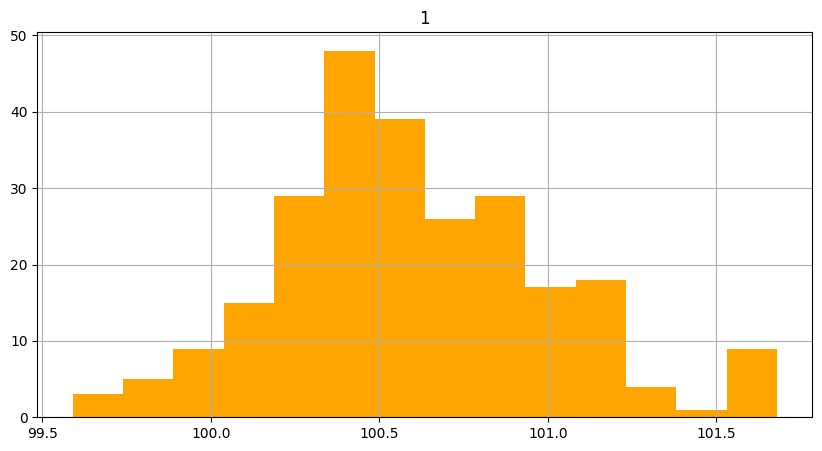

In [17]:
cleaned_df.hist(bins = 'fd', figsize=(10, 5), color='orange')

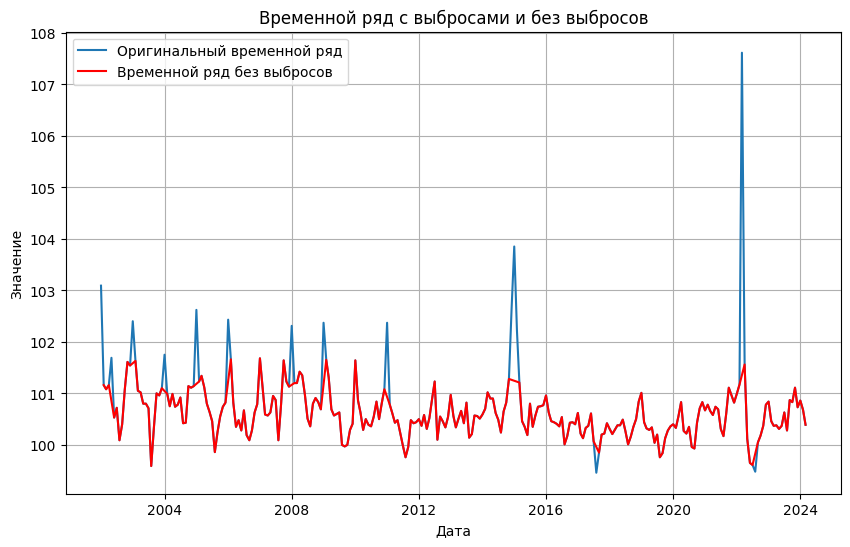

In [20]:
# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['1'], label='Оригинальный временной ряд')
plt.plot(cleaned_df.index, cleaned_df['1'], label='Временной ряд без выбросов', color='red')
plt.title('Временной ряд с выбросами и без выбросов')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

array([[<Axes: title={'center': '1'}>]], dtype=object)

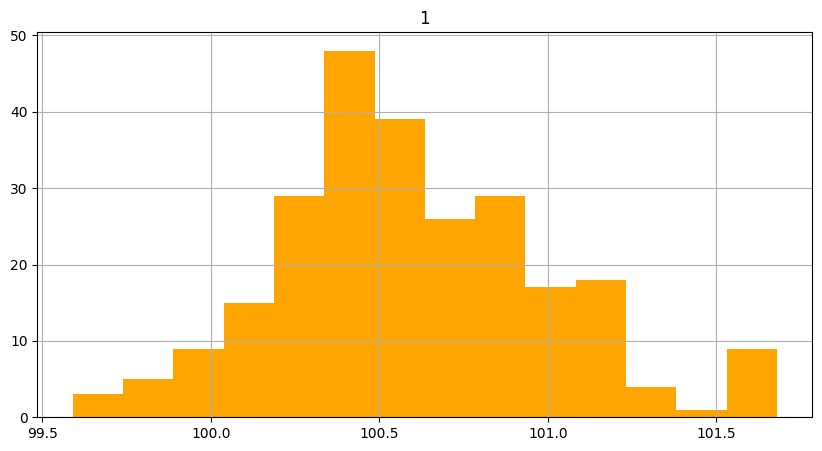

In [21]:
cleaned_df.hist(bins = 'fd', figsize=(10, 5), color='orange')

In [22]:
# Преобразуем временной ряд в одномерный массив значений
time_series = cleaned_df.values.flatten()

# Применяем тест Шапиро-Уилка
statistic, p_value = shapiro(time_series)

# Выводим результаты теста
print("Статистика теста:", statistic)
print("p-значение:", p_value)

# Оцениваем результаты теста
alpha = 0.05
if p_value > alpha:
    print("Принимаем нулевую гипотезу - данные имеют нормальное распределение")
else:
    print("Отвергаем нулевую гипотезу - данные не имеют нормального распределения")

Статистика теста: 0.984652578830719
p-значение: 0.008220151998102665
Отвергаем нулевую гипотезу - данные не имеют нормального распределения


In [23]:
missing_values = cleaned_df.index.isnull().sum()
if missing_values == 0:
    print("Пропущенных значений в индексе нет.")
else:
    print(f"Количество пропущенных значений в индексе: {missing_values}")

Пропущенных значений в индексе нет.


In [24]:
# Обучаем модель ARIMA на всех доступных данных, кроме последних 12 точек
model_hist = auto_arima(cleaned_df[:-12], seasonal=True, m=12, trace=True, suppress_warnings=True)

# Получаем прогноз для последних 12 точек
forecast = model_hist.predict(n_periods=12)

print(model_hist.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.19 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=190.298, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=190.774, Time=0.56 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=188.172, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=188.319, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=188.889, Time=0.22 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=190.040, Time=0.77 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=190.121, Time=1.12 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=188.090, Time=0.25 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=190.059, Time=0.80 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=192.038, Time=1.67 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=191.367, Time=0.33 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=1.18 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=in

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [25]:
forecast

240    100.452762
241    100.557842
242    100.413055
243    100.361319
244    100.358203
245    100.415913
246    100.432394
247    100.448681
248    100.491165
249    100.500934
250    100.457678
251    100.444204
dtype: float64

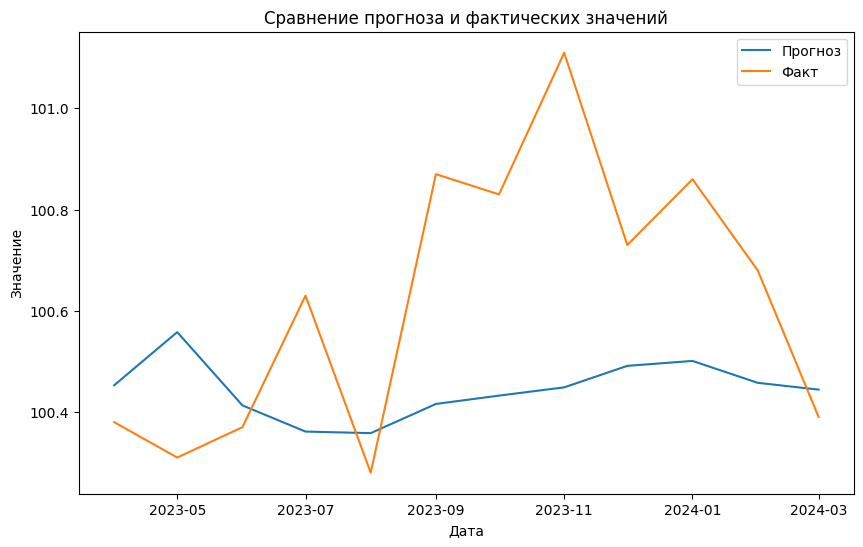

In [26]:
# Отображаем прогноз и фактические значения
plt.figure(figsize=(10, 6))
plt.plot(df.index[-12:], forecast, label='Прогноз')
plt.plot(df.index[-12:], df.iloc[-12:, 0], label='Факт')
plt.title('Сравнение прогноза и фактических значений')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [27]:
rmse = np.sqrt(mean_squared_error(df.iloc[-12:, 0], forecast))
print(f'RMSE: {rmse}')

RMSE: 0.31448940391648966


In [28]:
# Обучаем модель ARIMA на всех данных
model = auto_arima(cleaned_df, seasonal=True, m=12, trace=True, suppress_warnings=True)

# Получаем прогноз на 36 точек вперед
forecast_future = model.predict(n_periods=36)

# Ищем индекс, соответствующий январю 2020 года
start_date = pd.Timestamp('2020-01')

# Отображаем прогноз и фактические значения, начиная с января 2020 года

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=194.691, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=194.533, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=191.615, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=192.710, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=192.301, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=193.589, Time=1.04 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=193.605, Time=1.00 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=191.591, Time=0.28 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=193.590, Time=0.70 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=195.591, Time=0.89 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=195.806, Time=0.17 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=152.262, Time=1.66 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


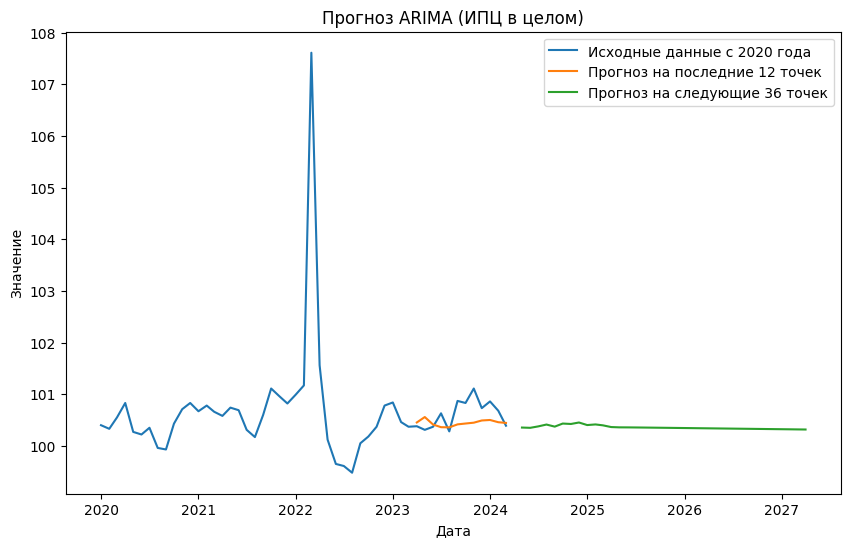

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  252
Model:             SARIMAX(1, 1, 2)x(0, 0, [1], 12)   Log Likelihood                 -64.096
Date:                              Tue, 16 Apr 2024   AIC                            140.191
Time:                                      08:28:45   BIC                            161.344
Sample:                                           0   HQIC                           148.704
                                              - 252                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0011      0.001     -2.029      0.042      -0.002   -3.75e-05
ar.L1          0.41

In [29]:
# Отображаем прогноз и фактические значения, начиная с января 2020 года
plt.figure(figsize=(10, 6))
plt.plot(df.index[df.index >= start_date], df[df.index >= start_date].values, label='Исходные данные с 2020 года')
plt.plot(df.index[-12:], forecast, label='Прогноз на последние 12 точек')
plt.plot(pd.date_range(start=df.index[-1], periods=37, freq='M')[1:], forecast_future, label='Прогноз на следующие 36 точек')
plt.title('Прогноз ARIMA (ИПЦ в целом)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()
print(model.summary())